# Consultas propuestas por el enunciado

#### Imports y definición de funciones

In [174]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
# suprimir future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def normalize_string_column_values(df, column_name):
    df[column_name] = df[column_name].str.upper()
    df[column_name] = df[column_name].str.strip()
    return df

### 1. ¿Cuál es el Estado que más descuentos tiene en total? ¿y en promedio?

#### Limpieza y preparación de columnas

In [175]:
orders = pd.read_csv(
    'data/orders.csv',
    usecols=[
        'order_id',
        'customer_id',
        'status',
        'payment_method',
        'billing_address',
        'discount_amount'
    ],
    dtype={
        'order_id': 'uint32',
        'customer_id': 'uint32',
        'discount_amount': 'float32',
        'status': 'category',
        'payment_method': 'category'
    },
)

In [176]:
orders = normalize_string_column_values(orders, 'status')
orders = normalize_string_column_values(orders, 'payment_method')
orders.fillna({"status":"UNDEFINED", "payment_method":"UNDEFINED"}, inplace=True)
orders['status'] = orders['status'].astype('category')
orders['payment_method'] = orders['payment_method'].astype('category')

In [177]:
orders["billing_address"] = orders["billing_address"].str.upper()
orders.fillna({"billing_address":"UNDEFINED"}, inplace=True)

# Los valores de "billing_address" se caracterizan por tener en alguna parte
# 2 letras mayúsculas seguidas de un espacio y 5 dígitos.
# Interpreto las dos letras mayúsculas como el Estado y los 5 dígitos como el código postal.
pattern = r'([A-Z]{2})\s(\d{5})'
orders[["state", "zip_code"]] = orders["billing_address"].str.extract(pattern)
orders.state = orders.state.astype('category')
orders.zip_code = orders.zip_code.astype('UInt32')

In [178]:
# Chequeo que la extracción haya salido bien
print("Filas totales en dataset orders:", len(orders))
print("Filas con estado no nulos:", orders["state"].notna().sum())
print("Filas con estado nulo:", orders["state"].isna().sum())

null_state_and_null_billing_addr = orders["state"].isna() & orders["billing_address"].str.contains("UNDEFINED")

print("¿Todas las filas que tienen estado nulo, tienen dirección de facturación indefinida?", 
        "Si" if null_state_and_null_billing_addr.sum() == orders["state"].isna().sum() else "No")

Filas totales en dataset orders: 4700000
Filas con estado no nulos: 4277862
Filas con estado nulo: 422138
¿Todas las filas que tienen estado nulo, tienen dirección de facturación indefinida? Si


#### Resolución

In [179]:
# Suposición: Si el valor de la columna "discount_amount" es nulo, es porque no hay descuento.
orders.fillna({"discount_amount":0.0}, inplace=True)

In [180]:
# Filtrar estados militares y otros
# filtro estos valores por interpretación de enunciado, 
# supongo que se refería a los 50 estados de EEUU
not_states_filter = ~(
    orders["state"].str.contains("AA")   # Military Americas
    | orders["state"].str.contains("AE") # Military Europe
    | orders["state"].str.contains("AP") # Military Pacific
    | orders["state"].str.contains("FM") # Federated States of Micronesia
    | orders["state"].str.contains("MH") # Marshall Islands
    | orders["state"].str.contains("MP") # Northern Mariana Islands
    | orders["state"].str.contains("PW") # Palau
    | orders["state"].str.contains("GU") # Guam
    | orders["state"].str.contains("VI") # U.S. Virgin Islands
    | orders["state"].str.contains("AS") # American Samoa
    | orders["state"].str.contains("PR") # Puerto Rico
    | orders["state"].str.contains("DC") # District of Columbia
    | orders["state"].isna()             # Nulos
)
print("Cantidad de estados considerados: ", orders.loc[not_states_filter]["state"].unique().size)

Cantidad de estados considerados:  50


In [181]:
import json
with open("state_names.json", "r") as f:
    state_names = json.load(f)

In [182]:
orders_with_discount = orders.loc[not_states_filter & orders["discount_amount"] > 0]
quantity_of_orders_with_discounts_by_state = \
    orders_with_discount\
        .groupby("state")["order_id"].count().reset_index()

quantity_of_orders_with_discounts_by_state["Nombre del Estado"] = quantity_of_orders_with_discounts_by_state["state"].map(state_names)
quantity_of_orders_with_discounts_by_state.rename(
    columns={
        "order_id": "Cantidad de Órdenes con Descuento",
        "state": "Código de Estado"
        }, inplace=True
    )

print("\nTop 5 estados con más órdenes con descuentos:")
quantity_of_orders_with_discounts_by_state.nlargest(5, "Cantidad de Órdenes con Descuento")


Top 5 estados con más órdenes con descuentos:


,Código de Estado,Cantidad de Órdenes con Descuento,Nombre del Estado
24,LA,13950,Louisiana
31,MO,13940,Missouri
20,IL,13930,Illinois
23,KY,13903,Kentucky
18,IA,13873,Iowa


In [183]:
states_avg_discount = orders_with_discount.groupby("state")["discount_amount"].mean().reset_index()
states_avg_discount["Nombre de Estado"] = states_avg_discount["state"].map(state_names)
states_avg_discount.rename(columns={
    "discount_amount": "Descuento Promedio",
    "state": "Código de Estado"   
    }, inplace=True
)
avg_discount = orders_with_discount["discount_amount"].mean()



print("\nDescuento promedio de las órdenes en todos los estados:", avg_discount)
print("\nTop 5 estados con mayor descuento promedio en las órdenes:")
states_avg_discount.nlargest(5, "Descuento Promedio")


Descuento promedio de las órdenes en todos los estados: 50.010773

Top 5 estados con mayor descuento promedio en las órdenes:


,Código de Estado,Descuento Promedio,Nombre de Estado
35,NC,50.673748,North Carolina
15,GA,50.462296,Georgia
44,OK,50.416782,Oklahoma
9,CO,50.336174,Colorado
33,MS,50.323948,Mississippi


### 2. ¿Cuáles son los 5 códigos postales más comunes para las órdenes con estado 'Refunded'? 
###    ¿Y cuál es el nombre más frecuente entre los clientes de esas direcciones?

#### Limpieza y preparación de columnas

In [184]:
customers = pd.read_csv(
    'data/customers.csv',
    usecols=[
        'customer_id',
        'first_name',
        'postal_code',
        'customer_segment',
        'is_active',
        'marketing_consent'
        ],
    dtype={
        'customer_id': 'uint32',
        'first_name': 'string',
        'customer_segment': 'category',
        'is_active': 'bool',
        'marketing_consent': 'bool'
    })

In [185]:
customers.postal_code = customers.postal_code.astype('UInt32') # como tiene valores nulos no lo puedo establecer al cargar el csv
customers = normalize_string_column_values(customers, 'first_name')
customers = normalize_string_column_values(customers, 'customer_segment')
customers.fillna({"first_name":"UNDEFINED", "customer_segment":"UNDEFINED"}, inplace=True)
customers.customer_segment = customers.customer_segment.astype('category')

#### Resolución

In [186]:
refunded_orders = orders[orders["status"].str.contains("REFUNDED")]

amount_refunded_orders_by_zipcode = refunded_orders["zip_code"].value_counts().reset_index()
top_refunded_zipcodes = amount_refunded_orders_by_zipcode.nlargest(5, "count")

print("\nTop 5 códigos postales más comunes para órdenes con estado 'Refunded':")
print(top_refunded_zipcodes)

# Hay varios que tienen 5 órdenes 'Refunded', por lo que los muestro todos
print("\nCódigos postales con 5 órdenes 'Refunded':")
print(amount_refunded_orders_by_zipcode.loc[amount_refunded_orders_by_zipcode["count"] == 5])



Top 5 códigos postales más comunes para órdenes con estado 'Refunded':
   zip_code  count
0     31571      6
1     65247      5
2     38151      5
3      9045      5
4     14396      5

Códigos postales con 5 órdenes 'Refunded':
   zip_code  count
1     65247      5
2     38151      5
3      9045      5
4     14396      5
5     73291      5
6     91623      5


In [187]:
most_common_names = customers.loc[customers["postal_code"].isin(top_refunded_zipcodes["zip_code"])]["first_name"].value_counts()

print("\nTop 5 nombres más comunes entre los clientes que realizaron órdenes 'Refunded' en los códigos postales con más órdenes 'Refunded':")
print(most_common_names.nlargest(5))

print("\nOtros nombres que aparecen una sola vez:")
print(most_common_names.loc[most_common_names == 1].head(7))


Top 5 nombres más comunes entre los clientes que realizaron órdenes 'Refunded' en los códigos postales con más órdenes 'Refunded':
first_name
UNDEFINED    4
RICHARD      2
MICHAEL      2
ROBERT       1
CYNTHIA      1
Name: count, dtype: Int64

Otros nombres que aparecen una sola vez:
first_name
ROBERT     1
CYNTHIA    1
JAY        1
MARIA      1
KAREN      1
CARLA      1
WILLIAM    1
Name: count, dtype: Int64


## 3. Para cada tipo de pago y segmento de cliente, <br>devolver la suma y el promedio expresado como porcentaje <br>de clientes activos y de consentimiento de marketing

#### Resolución

In [188]:
# Mergeo los dos dataframes porque necesito columnas de ambos:
# de customers: is_active, marketing_consent, customer_segment
# de orders:    payment_method
orders_customers = orders.merge(customers, on="customer_id").reset_index()

# Me quedo con filas únicas por combinación de método de pago y customer_id
# para no contar dos veces a un mismo cliente que hizo varias órdenes con el mismo método de pago
orders_customers_unique = orders_customers.drop_duplicates(subset=["payment_method", "customer_id"])

orders_customers_grouped = orders_customers_unique.groupby(["payment_method", "customer_segment"]).agg({
    "customer_id": "count",
    "is_active": ["sum", "mean"],
    "marketing_consent": ["sum", "mean"]
})
orders_customers_grouped[('is_active', 'mean')] *= 100
orders_customers_grouped[('marketing_consent', 'mean')] *= 100

In [189]:
orders_customers_grouped.columns = [
    'Total de usuarios',
    'Total de usuarios activos',
    'Porcentaje de usuarios activos',
    'Total de consentimientos de marketing',
    'Porcentaje de consentimientos de marketing'
]
orders_customers_grouped.index.set_names(['Método de Pago', 'Segmento de Cliente'], inplace=True)
orders_customers_grouped

Total de usuarios  \
Método de Pago   Segmento de Cliente                      
BANK TRANSFER    BUDGET                           17867   
                 PREMIUM                          18292   
                 REGULAR                          54606   
                 UNDEFINED                         9149   
CASH ON DELIVERY BUDGET                           17863   
                 PREMIUM                          18288   
                 REGULAR                          54620   
                 UNDEFINED                         9151   
CREDIT CARD      BUDGET                           17865   
                 PREMIUM                          18286   
                 REGULAR                          54614   
                 UNDEFINED                         9149   
DEBIT CARD       BUDGET                           17860   
                 PREMIUM                          18292   
                 REGULAR                          54606   
                 UNDEFINED                         9150   
DIGITAL WALLET   BUDGET                           17863   
                 PREMIUM                          18290   
                 REGULAR                          54606   
                 UNDEFINED                         9149   
PAYPAL           BUDGET                           17863   
                 PREMIUM                          18286   
                 REGULAR                          54620   
                 UNDEFINED                         9150   
UNDEFINED        BUDGET                           17598   
                 PREMIUM                          18004   
                 REGULAR                          53860   
                 UNDEFINED                         9028   

                                      Total de usuarios activos  \
Método de Pago   Segmento de Cliente                              
BANK TRANSFER    BUDGET                                   16041   
                 PREMIUM                                  16441   
                 REGULAR                                  49126   
                 UNDEFINED                                 8233   
CASH ON DELIVERY BUDGET                                   16040   
                 PREMIUM                                  16437   
                 REGULAR                                  49140   
                 UNDEFINED                                 8233   
CREDIT CARD      BUDGET                                   16039   
                 PREMIUM                                  16434   
                 REGULAR                                  49132   
                 UNDEFINED                                 8232   
DEBIT CARD       BUDGET                                   16034   
                 PREMIUM                                  16442   
                 REGULAR                                  49130   
                 UNDEFINED                                 8234   
DIGITAL WALLET   BUDGET                                   16039   
                 PREMIUM                                  16440   
                 REGULAR                                  49127   
                 UNDEFINED                                 8231   
PAYPAL           BUDGET                                   16039   
                 PREMIUM                                  16435   
                 REGULAR                                  49138   
                 UNDEFINED                                 8233   
UNDEFINED        BUDGET                                   15806   
                 PREMIUM                                  16172   
                 REGULAR                                  48441   
                 UNDEFINED                                 8123   

                                      Porcentaje de usuarios activos  \
Método de Pago   Segmento de Cliente                                   
BANK TRANSFER    BUDGET                                    89.780041   
                 PREMIUM                

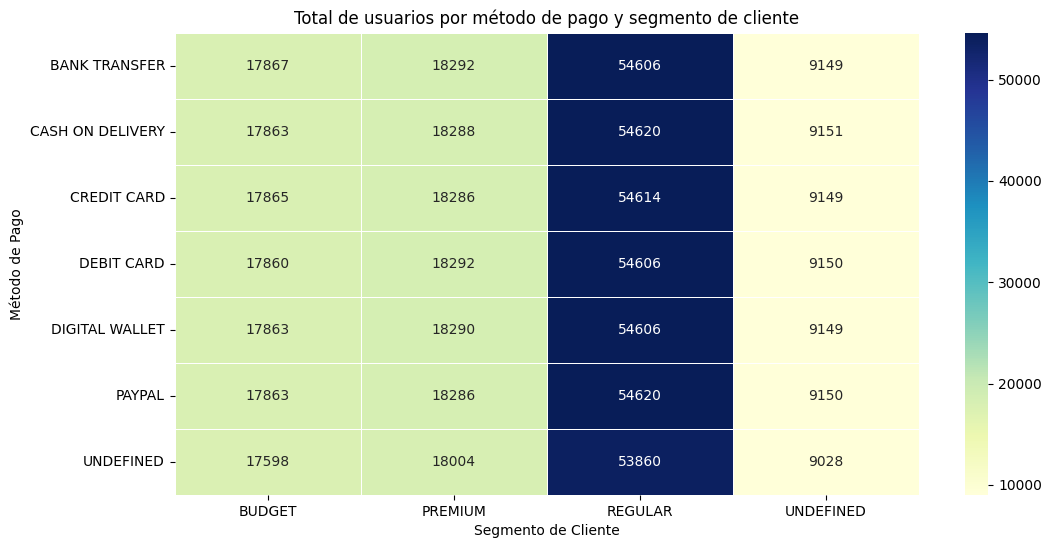

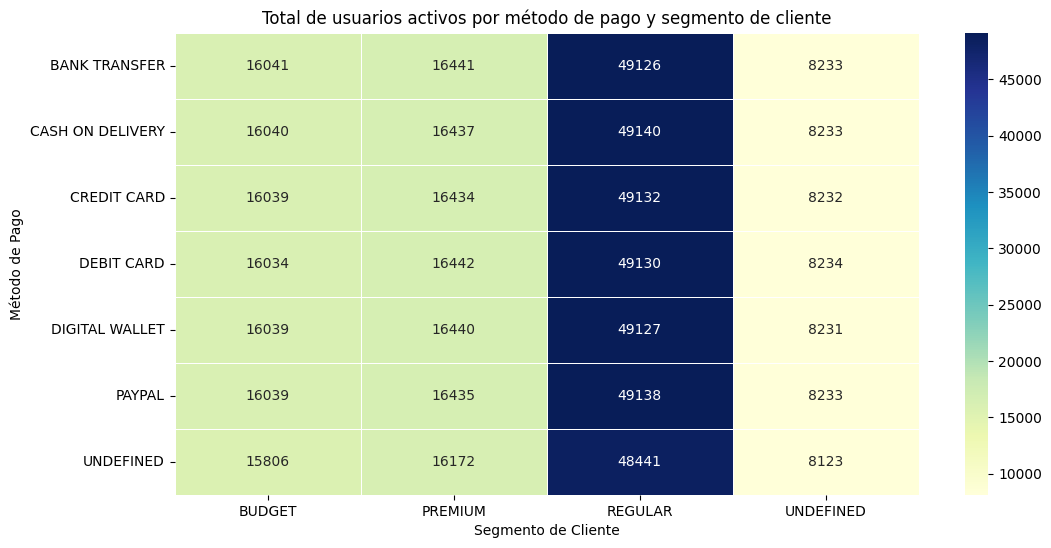

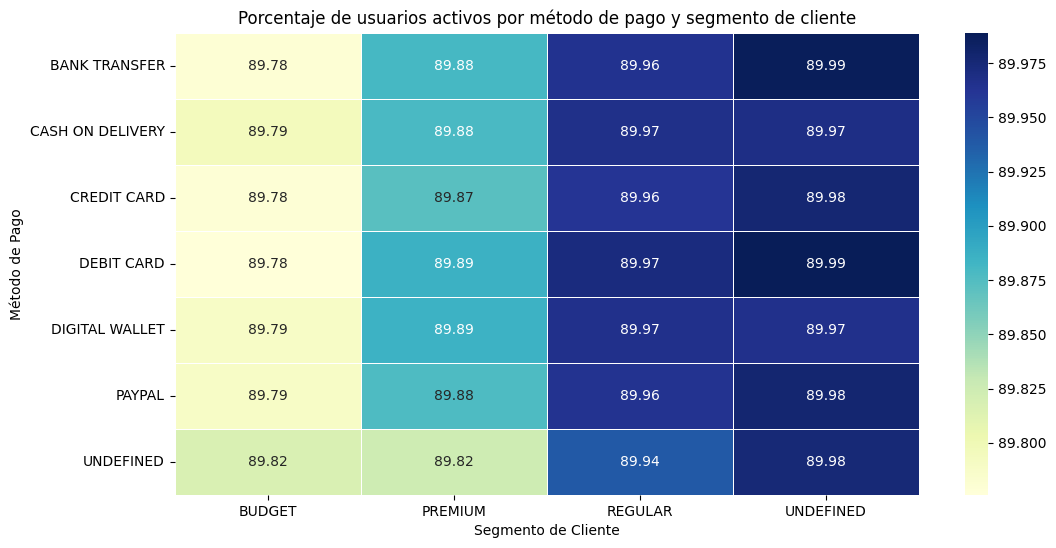

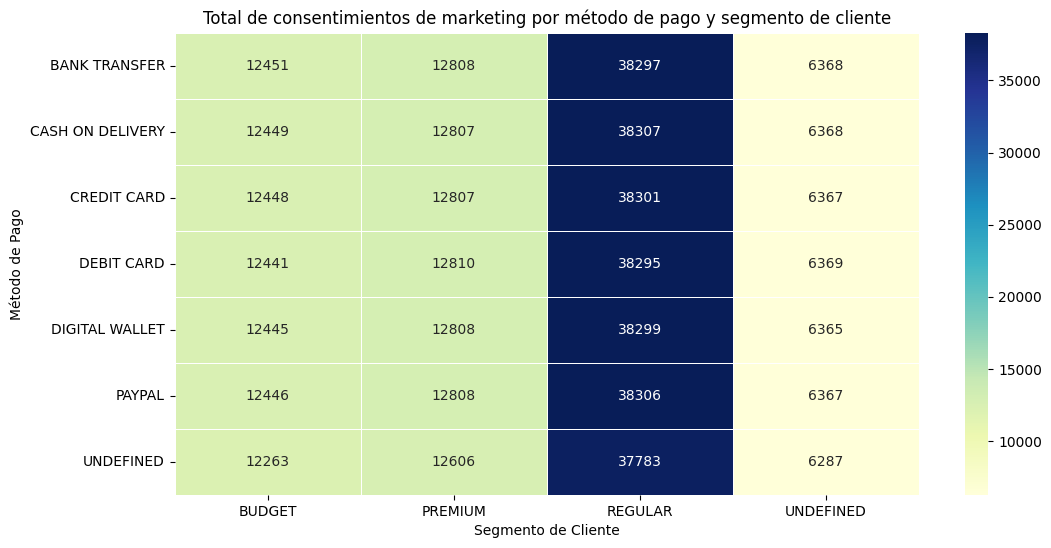

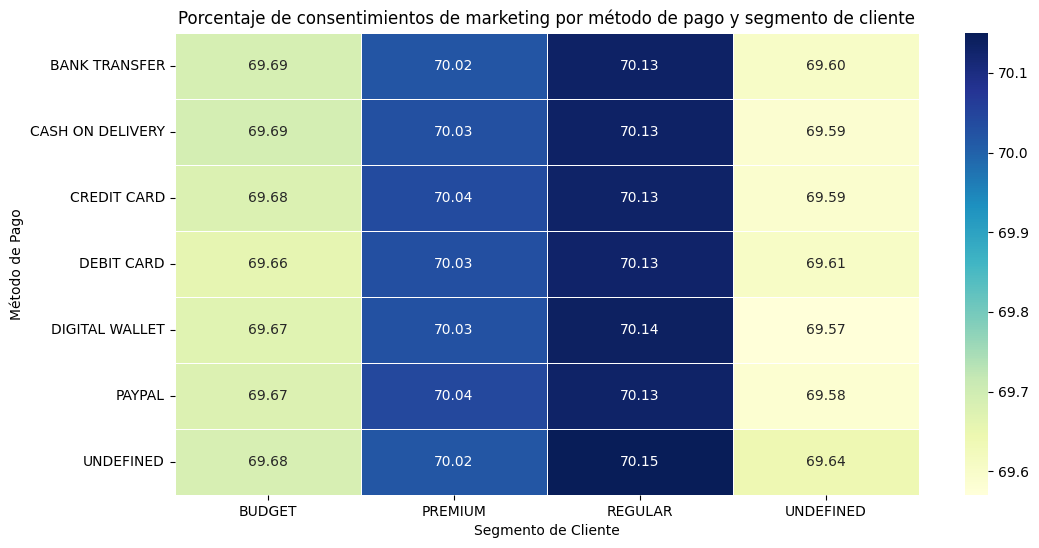

In [190]:
for col in orders_customers_grouped.columns:
    data = orders_customers_grouped[col].unstack()
    data = data.astype(float) # necesario para que funcione sns.heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        data, annot=True, cmap="YlGnBu", linecolor="white", linewidths=0.6,
        fmt=".0f" if col.startswith("Total") else ".2f"
    )
    plt.title(f'{col} por método de pago y segmento de cliente')

### 4. Para los productos que contienen en su descripción la palabra "stuff", <br> calcular el peso total de su inventario agrupado por marca, <br> mostrar sólo la marca y el peso total de las 5 más pesadas

#### Limpieza y preparación de columnas

In [191]:
products = pd.read_csv(
    'data/products.csv',
    usecols=[
        'product_id',
        'category_id',
        'brand',
        'stock_quantity',
        'weight_kg',
        'description'
    ],
    dtype={
        'product_id': 'uint32',
        'category_id': 'uint32',
        'brand': 'category',
        'weight_kg': 'float32',
        'description': 'string'
    })

In [192]:
products.stock_quantity = products.stock_quantity.astype('UInt32') # como tiene valores nulos no lo puedo establecer al cargar el csv

products = normalize_string_column_values(products, 'brand')
products.fillna({"brand":"UNDEFINED"}, inplace=True)
products.brand = products.brand.astype('category')

products.description = products.description.fillna("")

#### Resolución

In [193]:
# Asumo que la columna `"weight_kg"` es el peso unitario del producto en el inventario.
stuff_products = products.loc[products["description"].str.contains("STUFF", case=False)][["brand", "weight_kg", "stock_quantity"]]
stuff_products["total_weight_kg"] = stuff_products["weight_kg"] * stuff_products["stock_quantity"]
stuff_products.drop(columns=["weight_kg", "stock_quantity"], inplace=True)
stuff_products.columns = ["Marca", "Peso Total (kg)"]
stuff_products.groupby("Marca")["Peso Total (kg)"].sum().nlargest(5)

Marca
UNDEFINED    11157882.664793
3M            2250899.667691
ADIDAS        1923907.879408
NIKE          1783569.897482
HASBRO        1714411.235516
Name: Peso Total (kg), dtype: Float64